In [ ]:
# %pip install tqdm
# %pip install python-dotenv
# %pip install torch==2.4.0+cu118
# %pip install scikit_learn==1.2.2
# %pip install ipython
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install tabulate
# %pip install scipy
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit

In [1]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from dotenv import load_dotenv
from model.CNN import ConditionalSegmentationVAE
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from torch import nn
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

- Dataset

In [2]:
if not os.path.exists(DATA_DIR): raise FileNotFoundError("Make sure the data directory is correctly placed.")

In [3]:
files = get_files(DATA_DIR)

return_list = []
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']

original dataset size: 238
dataset size with duplicates removed: 172


In [ ]:
# for idx, label in enumerate(labels):
#     plt.imshow(labels[idx])
#     plt.savefig(f'../fig/{idx}_{file_name}.png')
#     plt.show()


- x y splitting

In [4]:
from sklearn.model_selection import train_test_split


unique_labels = [u for u in labels if np.array(np.where(u != 0)).T.shape[0] > 1]
padded_labels = []
for label in unique_labels:
    unique_vals = np.unique(label)[1:]
    new_vals = []
    count = 0
    for val in unique_vals:    
        dummy_vals = np.zeros(label.shape)
        dummy_vals[np.where(label == val)] = 1
        new_vals.append(dummy_vals)
        count += 1
    for i in range(count, MAX_LEN):
        dummy_vals = np.zeros(label.shape)
        new_vals.append(dummy_vals)
    new_vals = np.array(new_vals)
    padded_labels.append(new_vals)
train_labels, test_labels = train_test_split(unique_labels, test_size=.2)


In [5]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_channels, img_width, img_height, start_dim, n_layers, latent_dim):
        """
        Fully Connected Encoder.
        
        Args:
            input_channels (int): Number of input channels (e.g., 3 for RGB).
            img_width (int): Image width.
            img_height (int): Image height.
            start_dim (int): Size of the first hidden layer.
            n_layers (int): Number of hidden layers (each doubling the previous size).
            latent_dim (int): Size of the latent representation.
        """
        super(Encoder, self).__init__()
        input_size = input_channels * img_width * img_height
        layers = []
        # First layer: from flattened input to start_dim
        layers.append(nn.Linear(input_size, start_dim))
        layers.append(nn.Mish())
        hidden_dim = start_dim
        # Add n_layers that double the hidden size at each layer
        for _ in range(n_layers):
            next_dim = hidden_dim * 2
            layers.append(nn.Linear(hidden_dim, next_dim))
            layers.append(nn.Mish())
            hidden_dim = next_dim
        # Final layer to produce latent representation
        layers.append(nn.Linear(hidden_dim, latent_dim))
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten input: (B, C, W, H) -> (B, C*W*H)
        x = x.view(x.size(0), -1)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, output_channels, img_width, img_height, start_dim, n_layers, latent_dim):
        """
        Fully Connected Decoder.
        
        Args:
            output_channels (int): Number of output channels (should match input_channels).
            img_width (int): Image width.
            img_height (int): Image height.
            start_dim (int): Should match the start_dim used in the encoder.
            n_layers (int): Number of hidden layers (used in encoder, in reverse order here).
            latent_dim (int): Size of the latent representation.
        """
        super(Decoder, self).__init__()
        output_size = output_channels * img_width * img_height
        layers = []
        # For symmetry, assume the encoder’s last hidden dimension was start_dim * (2 ** n_layers)
        hidden_dim = start_dim * (2 ** n_layers)
        # First layer: from latent_dim to hidden_dim
        layers.append(nn.Linear(latent_dim, hidden_dim))
        layers.append(nn.Mish())
        # Then, for each layer, halve the hidden dimension
        for _ in range(n_layers):
            next_dim = hidden_dim // 2
            layers.append(nn.Linear(hidden_dim, next_dim))
            layers.append(nn.Mish())
            hidden_dim = next_dim
        # Final layer: output layer to reconstruct the flattened image
        layers.append(nn.Linear(hidden_dim, output_size))
        self.decoder = nn.Sequential(*layers)
        self.output_channels = output_channels
        self.img_width = img_width
        self.img_height = img_height

    def forward(self, z):
        x = self.decoder(z)
        # Reshape back to image dimensions: (B, output_channels, img_width, img_height)
        x = x.view(x.size(0), self.output_channels, self.img_width, self.img_height)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels):
        """
        Fully Connected Autoencoder (combining the encoder and decoder).
        """
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim)
        self.decoder = Decoder(output_channels, img_width, img_height, start_dim, n_layers, latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def generate(input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels, device="cpu", output_type="autoencoder"):
    """
    Creates an encoder, decoder, or autoencoder model based on user input.

    Args:
        input_channels (int): Number of input channels (e.g., 3 for RGB).
        img_width (int): Image width.
        img_height (int): Image height.
        start_dim (int): The size of the first hidden layer.
        n_layers (int): Number of hidden layers (each doubling the dimension in the encoder).
        latent_dim (int): Size of the latent representation.
        output_channels (int): Number of output channels (should match input_channels).
        device (str): 'cpu' or 'cuda'.
        output_type (str): 'encoder', 'decoder', or 'autoencoder'.

    Returns:
        A PyTorch model on the selected device.
    """
    device = torch.device(device)

    if output_type == "encoder":
        model = Encoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim)
    elif output_type == "decoder":
        model = Decoder(output_channels, img_width, img_height, start_dim, n_layers, latent_dim)
    elif output_type == "autoencoder":
        model = Autoencoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels)
    else:
        raise ValueError("Invalid output_type. Choose from 'encoder', 'decoder', or 'autoencoder'.")
    return model.to(device)


- data processing

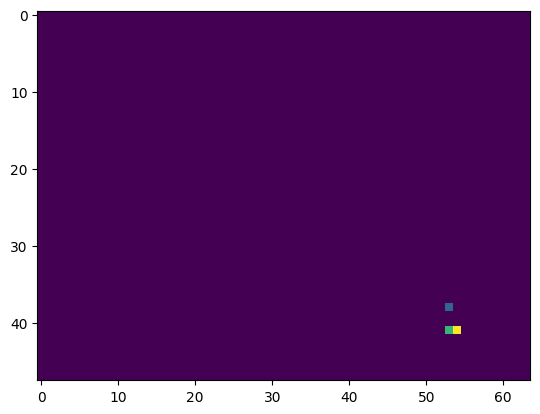

In [10]:
x, y = next(iter(loader))
plt.imshow(x[0])

In [11]:

loader, val_loader = xy_to_tensordataset(
    train_labels, train_labels,
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
)

In [32]:
from mkit.torch_support.nn_utils import training_loop
model = Autoencoder(1, WIDTH, HEIGHT, start_dim=64, n_layers=2, latent_dim=12, output_channels=1)
training_loop(
    model, 
    train_loader=loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adamax(model.parameters()),
    criterion=nn.L1Loss(),
    device=torch.device('cuda'),
    epochs=100,
    early_stopping=True
)

EPOCH 1/100:   0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\ss348\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([8, 48, 64])) that is different to the input size (torch.Size([8, 1, 48, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
EPOCH 1/100:  53%|█████▎    | 8/15 [00:00<00:00, 72.28it/s]c:\Users\ss348\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 48, 64])) that is different to the input size (torch.Size([1, 1, 48, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
EPOCH 1/100: 100%|██████████| 15/15 [00:00<00:00, 63.20it/s]
c:\Users\ss348\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([3, 48, 64])) that is different to the i

Epoch [1/100] Training Loss: 0.0357  Validation Loss: 0.0125



EPOCH 2/100: 100%|██████████| 15/15 [00:00<00:00, 96.84it/s]


Epoch [2/100] Training Loss: 0.0082  Validation Loss: 0.0051



EPOCH 3/100: 100%|██████████| 15/15 [00:00<00:00, 105.19it/s]


Epoch [3/100] Training Loss: 0.0042  Validation Loss: 0.0034



EPOCH 4/100: 100%|██████████| 15/15 [00:00<00:00, 103.99it/s]


Epoch [4/100] Training Loss: 0.0033  Validation Loss: 0.0030



EPOCH 5/100: 100%|██████████| 15/15 [00:00<00:00, 102.29it/s]


Epoch [5/100] Training Loss: 0.0030  Validation Loss: 0.0030



EPOCH 6/100: 100%|██████████| 15/15 [00:00<00:00, 108.79it/s]


Epoch [6/100] Training Loss: 0.0030  Validation Loss: 0.0028



EPOCH 7/100: 100%|██████████| 15/15 [00:00<00:00, 89.77it/s]


Epoch [7/100] Training Loss: 0.0029  Validation Loss: 0.0027



EPOCH 8/100: 100%|██████████| 15/15 [00:00<00:00, 104.39it/s]


Epoch [8/100] Training Loss: 0.0027  Validation Loss: 0.0028



EPOCH 9/100: 100%|██████████| 15/15 [00:00<00:00, 98.21it/s]


Epoch [9/100] Training Loss: 0.0027  Validation Loss: 0.0027



EPOCH 10/100: 100%|██████████| 15/15 [00:00<00:00, 80.47it/s]


Epoch [10/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 11/100: 100%|██████████| 15/15 [00:00<00:00, 106.14it/s]


Epoch [11/100] Training Loss: 0.0028  Validation Loss: 0.0027



EPOCH 12/100: 100%|██████████| 15/15 [00:00<00:00, 93.68it/s]


Epoch [12/100] Training Loss: 0.0028  Validation Loss: 0.0027



EPOCH 13/100: 100%|██████████| 15/15 [00:00<00:00, 99.47it/s]


Epoch [13/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 14/100: 100%|██████████| 15/15 [00:00<00:00, 109.68it/s]


Epoch [14/100] Training Loss: 0.0028  Validation Loss: 0.0027



EPOCH 15/100: 100%|██████████| 15/15 [00:00<00:00, 105.69it/s]


Epoch [15/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 16/100: 100%|██████████| 15/15 [00:00<00:00, 94.20it/s]

Epoch [16/100] Training Loss: 0.0027 

 Validation Loss: 0.0026



EPOCH 17/100: 100%|██████████| 15/15 [00:00<00:00, 102.23it/s]


Epoch [17/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 18/100: 100%|██████████| 15/15 [00:00<00:00, 88.74it/s]


Epoch [18/100] Training Loss: 0.0027  Validation Loss: 0.0027



EPOCH 19/100: 100%|██████████| 15/15 [00:00<00:00, 104.52it/s]


Epoch [19/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 20/100: 100%|██████████| 15/15 [00:00<00:00, 98.27it/s] 


Epoch [20/100] Training Loss: 0.0027  Validation Loss: 0.0027



EPOCH 21/100: 100%|██████████| 15/15 [00:00<00:00, 102.33it/s]


Epoch [21/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 22/100: 100%|██████████| 15/15 [00:00<00:00, 94.05it/s]


Epoch [22/100] Training Loss: 0.0027  Validation Loss: 0.0027



EPOCH 23/100: 100%|██████████| 15/15 [00:00<00:00, 93.01it/s]


Epoch [23/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 24/100: 100%|██████████| 15/15 [00:00<00:00, 87.66it/s]


Epoch [24/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 25/100: 100%|██████████| 15/15 [00:00<00:00, 100.85it/s]


Epoch [25/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 26/100: 100%|██████████| 15/15 [00:00<00:00, 93.16it/s]


Epoch [26/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 27/100: 100%|██████████| 15/15 [00:00<00:00, 85.83it/s]


Epoch [27/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 28/100: 100%|██████████| 15/15 [00:00<00:00, 102.54it/s]


Epoch [28/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 29/100: 100%|██████████| 15/15 [00:00<00:00, 99.69it/s] 

Epoch [29/100] Training Loss: 0.0028

  Validation Loss: 0.0026



EPOCH 30/100: 100%|██████████| 15/15 [00:00<00:00, 92.43it/s]


Epoch [30/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 31/100: 100%|██████████| 15/15 [00:00<00:00, 96.17it/s]


Epoch [31/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 32/100: 100%|██████████| 15/15 [00:00<00:00, 96.53it/s]


Epoch [32/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 33/100: 100%|██████████| 15/15 [00:00<00:00, 101.53it/s]


Epoch [33/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 34/100: 100%|██████████| 15/15 [00:00<00:00, 105.22it/s]


Epoch [34/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 35/100: 100%|██████████| 15/15 [00:00<00:00, 81.89it/s]


Epoch [35/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 36/100: 100%|██████████| 15/15 [00:00<00:00, 100.31it/s]


Epoch [36/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 37/100: 100%|██████████| 15/15 [00:00<00:00, 95.17it/s]


Epoch [37/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 38/100: 100%|██████████| 15/15 [00:00<00:00, 110.23it/s]


Epoch [38/100] Training Loss: 0.0028  Validation Loss: 0.0026



EPOCH 39/100: 100%|██████████| 15/15 [00:00<00:00, 102.21it/s]


Epoch [39/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 40/100: 100%|██████████| 15/15 [00:00<00:00, 95.14it/s]


Epoch [40/100] Training Loss: 0.0027  Validation Loss: 0.0026



EPOCH 41/100: 100%|██████████| 15/15 [00:00<00:00, 101.47it/s]

Epoch [41/100] Training Loss: 0.0027  Validation Loss: 0.0026

Training stopped after 6 consecutive iterations without improvement.
Training completed.
Best validation loss: 0.0025809326519568763, model loaded with the selected parameters


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=3072, out_features=64, bias=True)
      (1): Mish()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): Mish()
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): Mish()
      (6): Linear(in_features=256, out_features=12, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=12, out_features=256, bias=True)
      (1): Mish()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Mish()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): Mish()
      (6): Linear(in_features=64, out_features=3072, bias=True)
    )
  )
)

- For Machine Learning Models
    - To fit the data formats of tensors, every sci-kit learn model needs to be wrapped inside the object MLWrapper

In [37]:
pred = model(torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda')))


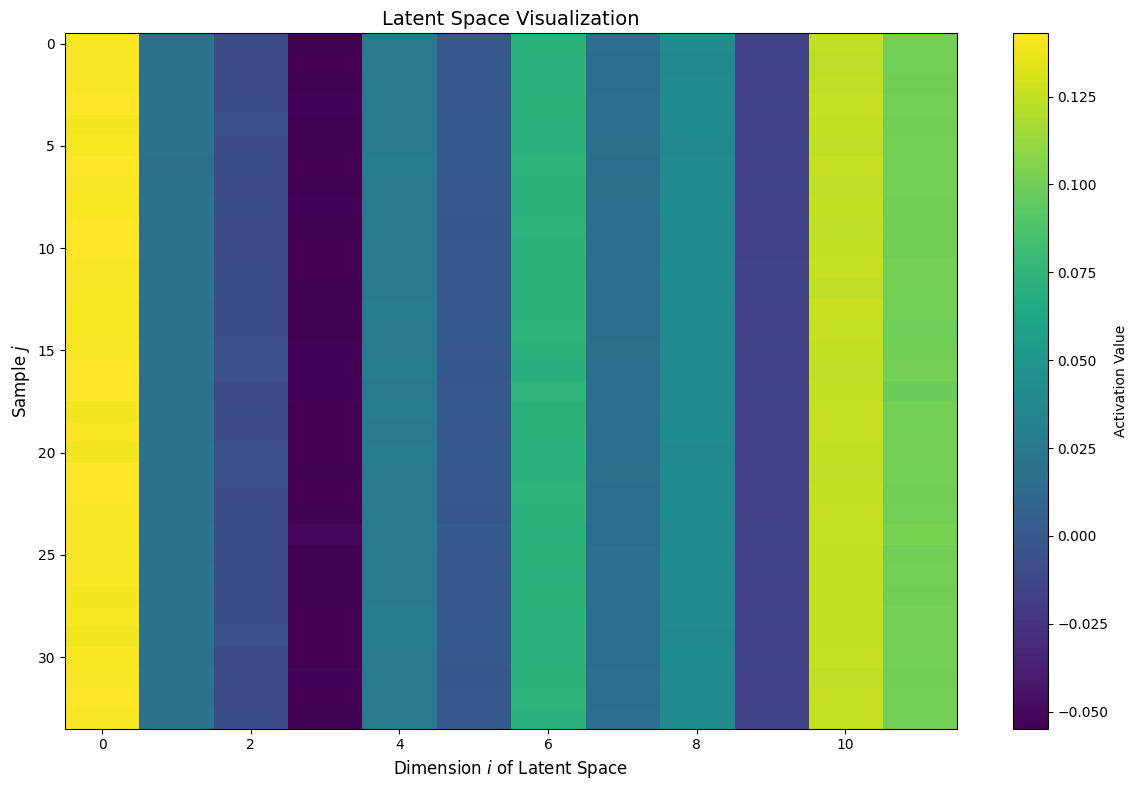

In [45]:


# Compute the latent representation from the test labels
latent = model.encoder(
    torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda'))
).detach().cpu().numpy()

# Create a figure with a suitable size
plt.figure(figsize=(12, 8))

# Display the latent space matrix
im = plt.imshow(latent, aspect='auto', cmap='viridis')

# Add labels, title, and a colorbar for reference
plt.xlabel(r'Dimension $i$ of Latent Space', fontsize=12)
plt.ylabel(r'Sample $j$', fontsize=12)
plt.title("Latent Space Visualization", fontsize=14)
plt.colorbar(im, label='Activation Value')

# Adjust layout to prevent clipping of labels and title
plt.tight_layout()
plt.show()


In [35]:
import os
import matplotlib.pyplot as plt

idx = 0
pred_img, label_img  = pred.squeeze(1)[idx].cpu().detach(), test_labels[idx]
# Create a figure with 1 row and 2 columns, and set an appropriate figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot prediction image with a title and a shrunken colorbar with some padding
im0 = axes[0].imshow(pred_img, cmap='viridis')
axes[0].set_title("Prediction")
fig.colorbar(im0, ax=axes[0], shrink=0.7, pad=0.05)

# Plot ground truth image with a title and a shrunken colorbar with some padding
print(label_img.shape)
im1 = axes[1].imshow(label_img, cmap='viridis')
axes[1].set_title("Ground Truth")
fig.colorbar(im1, ax=axes[1], shrink=0.7, pad=0.05)

# Adjust layout to leave space for the suptitle
fig.subplots_adjust(top=0.85)
NAME = f"Autoencoder_{count}_L1"
fig.suptitle(NAME, fontsize=16)

# Create output directory if it doesn't exist
PATH = f'../fig/AE_L1/{idx}'
os.makedirs(PATH, exist_ok=True)

# Save and close the figure
plt.savefig(f"{PATH}/{NAME}.png")
plt.close(fig)


(48, 64)


In [12]:
class MLWrapper(nn.Module):
    def __init__(self, model_object = RandomForestRegressor, **args):
        self.model = model_object(**args)
        self.device = torch.device('cpu')
    def loader_to_xy(self, loader):
        x, y = loader.dataset.tensors
        x, y = np.array(x).squeeze(1), np.array(y)
        x = x.reshape(x.shape[0], -1)
        return x, y
    def fit(self, train_loader, val_loader):
        train_x, train_y = self.loader_to_xy(train_loader)
        val_train_x, val_train_y = self.loader_to_xy(val_loader)
        self.model.fit(train_x, train_y)
        accu = self.model.score(val_train_x, val_train_y)
        print(accu)
    def inference(self, img):
        batch_size, _, _, _ = img.shape
        img = img.reshape(batch_size, -1)
        return torch.tensor(self.model.predict(img))

- VAE

In [ ]:
IMG_CHANNELS = 1    # For grayscale images; use 3 for RGB.
N_EPOCHS = 100      # Adjust as needed.
LATENT_DIM = 300    # Dimensionality of the latent space.
FEATURE_MAPS = 8    # Base number of feature maps.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalSegmentationVAE(
    latent_dim=LATENT_DIM,
    width=WIDTH,
    height=HEIGHT,
    img_channels=IMG_CHANNELS,
    feature_maps=FEATURE_MAPS,
    device=device
)

segmentation_loss_fn = nn.BCEWithLogitsLoss().to(device)

# Assume your train_loader and val_loader are defined appropriately.
model.train_vae(
    train_loader=loader,       # your training DataLoader
    val_loader=val_loader,       # your validation DataLoader
    n_epochs=N_EPOCHS,
    seg_criterion=segmentation_loss_fn,
    kl_weight=0.001,
    patience=10,
    device=device
)
clear_output(wait=True)

In [ ]:

evaluate_and_plot(test_loader, model=model, encoder=encoder, title='VAE', dataset_name=city_name)

- Random Forest

In [ ]:


model = MLWrapper()
model.fit(loader, val_loader)
evaluate_and_plot(test_loader, model=model, encoder=encoder, title='RF', dataset_name=city_name)